# Optymalizacja punktu cut-off

In [1]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,precision_score,recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# puść ten kod, 
# jeżeli wywołujesz plik  w folderze rozwiąznaia, 
# a ramka danych znajduje się w folderze data
import os 
os.chdir('../')

In [3]:
# Wczytanie zbioru danych
df = pd.read_csv('data/credit_fraud_sample.csv')
del df['Unnamed: 0']

In [3]:
## Pretrenuj model
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,1:3],df['Class'], test_size=0.3, random_state=123)
model = LogisticRegression().fit(train_x,train_y)
train_pred = model.predict_proba(train_x)[:,1]
test_pred = model.predict_proba(test_x)[:,1]
df['predict_proba'] = model.predict_proba(df[model.feature_names_in_])[:,1]

In [4]:
# Przygotwanie danych
fpr_train , tpr_train , thresholds_train = roc_curve(train_y, train_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(test_y, test_pred)

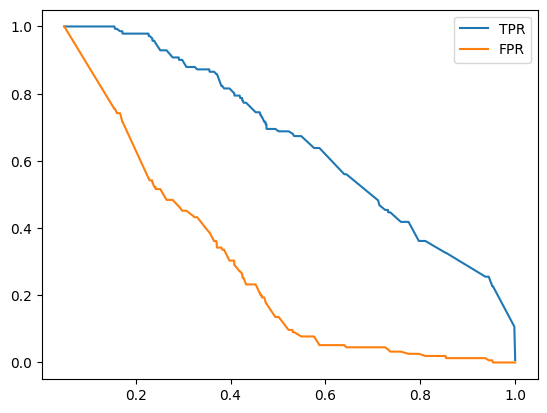

In [5]:
# Wykres
plt.plot(thresholds_test, tpr_test, label= 'TPR')
plt.plot(thresholds_test, fpr_test, label = 'FPR')
plt.legend()
plt.show()

Jeżeli zależy nam na dobrej identyfikacji 1 ze wszystkich przypadków ze zbioru, możemy wybrać cut-off, tam gdzie TPR jest wysoki, FPR będzie również wysoki, ale może to być mniejszym kosztem. Przykładem może być wykrywalność choroby. Chcemy znaleźć wszystkich chorych, nawet jeżeli wiąże się to ze zleceniem badań wielu osobom, które nie są chore.

In [6]:
# Y train df
train_pred_df = pd.DataFrame()
train_pred_df['y_true'] = train_y 
train_pred_df['y_pred'] = train_pred

In [7]:
# Y test df
test_pred_df = pd.DataFrame()
test_pred_df['y_true'] = test_y 
test_pred_df['y_pred'] = test_pred
test_pred_df

,y_true,y_pred
300,0,0.199024
778,1,0.624826
531,1,0.275817
863,1,0.775185
182,0,0.407731
...,...,...
929,1,0.229543
668,1,0.644452
577,1,0.655196
178,0,0.125597


In [10]:
# Wyliczenie miar test
precisions = []
recalls = []
avg_values = []
f1_scores = []

for i in range(len(thresholds_test)):
    cut_off = thresholds_test[i]
    pred_class = (test_pred_df['y_pred'] >=cut_off).astype(int)
    pr = precision_score(test_pred_df['y_true'], pred_class)
    rs = recall_score(test_pred_df['y_true'], pred_class)
    f1 = f1_score(test_pred_df['y_true'],pred_class)
    avg = (pr+rs)/2
    precisions.append(pr)
    recalls.append(rs)
    f1_scores.append(f1)
    avg_values.append(avg)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


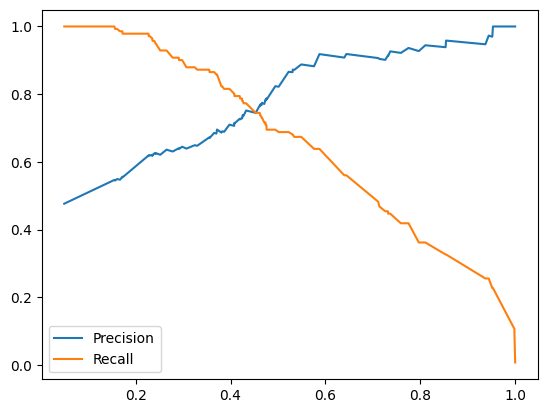

In [11]:
# Wykres
plt.plot(thresholds_test, precisions, label = 'Precision')
plt.plot(thresholds_test, recalls,label = 'Recall')
plt.legend()
plt.show()

In [12]:
# Cut-off
thresholds_test[f1_scores.index(max(f1_scores))]


np.float64(0.37145619093995746)

In [13]:
thresholds_test[avg_values.index(max(avg_values))]

np.float64(0.22712955117593778)

## Klasy prawdopodobieństwa

In [ ]:
# podział według kwantyli
train_pred_df['pred_class'] = pd.qcut(train_pred_df['y_pred'],q=4,)

In [15]:
# odsetek 1 w klasach
train_pred_df.groupby('pred_class').mean()['y_true']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11512\205865194.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_pred_df.groupby('pred_class').mean()['y_true']


pred_class
(0.0441, 0.223]    0.116279
(0.223, 0.445]     0.354651
(0.445, 0.793]     0.633721
(0.793, 1.0]       0.936047
Name: y_true, dtype: float64

In [31]:
# Funkcja do przypisania klasy
def assign_class(x):
    cuts = [0.223,0.445, 0.793,1]
    ranges = ['(0.0441, 0.223]','(0.223, 0.445]','(0.445, 0.793]','(0.793, 1.0]']
    for i in range(len(cuts)):
        if x <= cuts[i]:
            return ranges[i]


In [32]:
# Przypisanie na zbiorze testowym
test_pred_df['pred_class']  = test_pred_df.loc[:,'y_pred'].apply(lambda x: assign_class(x))

In [33]:
# Sprawdzenie
test_pred_df.groupby('pred_class').mean()['y_true']

pred_class
(0.0441, 0.223]    0.041667
(0.223, 0.445]     0.390244
(0.445, 0.793]     0.632184
(0.793, 1.0]       0.927273
Name: y_true, dtype: float64